In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [3]:
spark_generator = NewsHeadlines(#locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/54 [00:00<?, ?it/s]

In [4]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
ctx['seed'] = 2226123#3357669#6660483
# ctx['spark'] = '''Title: Naples, Apple renews the Academy program with the Federico II University - Rai News
# Description: The academic training born between Cupertino and the University in 2016 restarts at the San Giovanni a Teduccio headquarters
# Original Language: Italian'''
print(ctx['seed'])
print(ctx['spark'])

2226123
Title: Larisa Kuklina: “This is the first time I celebrate a birthday with tears in my eyes” - news.Sportbox.ru
Description: Russian biathlete Larisa Kuklina summed up her performance at the 3rd stage of the relay and also talked about her injured hand.
Original Language: Russian


In [5]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Larisa Kuklina: “This is the first time I celebrate a birthday with tears in my eyes” - news.Sportbox.ru
Description: Russian biathlete Larisa Kuklina summed up her performance at the 3rd stage of the relay and also talked about her injured hand.
Original Language: Russian
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "st

In [6]:
##############################################
motivation_raw = '''

{
  "title": "Larisa Kuklina's Performance and Injury Analysis",
  "introduction": "In light of Larisa Kuklina's emotional birthday celebration following her recent relay race, a closer look at her performance data could reveal intriguing patterns. By examining her race times, shooting accuracy, and results before and after her hand injury, we might uncover how such physical setbacks impact an athlete's overall performance. This exploration can shed light on the resilience and adaptability of athletes facing unexpected challenges."
}




'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [7]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [12]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''

[
  {
    "name": "Performance Decline",
    "description": "Decline in biathlon performance, observable through race times and results.",
    "type": "outcome",
    "observed": true,
    "values": ["No Decline", "Decline"],
    "parents": ["Physical Fitness", "Shooting Accuracy"]
  },
  {
    "name": "Hand Injury",
    "description": "Injury to the hand, affecting physical ability in biathlon.",
    "type": "treatment",
    "observed": true,
    "values": ["No Injury", "Injury"],
    "parents": ["Training Intensity"]
  },
  {
    "name": "Mental Stress",
    "description": "Psychological stress potentially affecting performance.",
    "type": "treatment",
    "observed": true,
    "values": ["No Stress", "Stress"],
    "parents": ["Previous Performance"]
  },
  {
    "name": "Training Intensity",
    "description": "Level of intensity in training sessions before the race.",
    "type": "confounder",
    "observed": true,
    "values": ["Low Intensity", "High Intensity"],
    "parents": []
  },
  {
    "name": "Previous Performance",
    "description": "Athlete's performance in prior events.",
    "type": "confounder",
    "observed": true,
    "values": ["Poor Performance", "Good Performance"],
    "parents": []
  },
  {
    "name": "Physical Fitness",
    "description": "Overall physical condition and fitness of the athlete.",
    "type": "mediator",
    "observed": true,
    "values": ["Low Fitness", "High Fitness"],
    "parents": ["Hand Injury", "Training Intensity"]
  },
  {
    "name": "Shooting Accuracy",
    "description": "Accuracy in shooting, a critical component in biathlon.",
    "type": "mediator",
    "observed": true,
    "values": ["Low Accuracy", "High Accuracy"],
    "parents": ["Hand Injury", "Mental Stress"]
  },
  {
    "name": "Media Attention",
    "description": "Level of media attention received by the athlete.",
    "type": "collider",
    "observed": true,
    "values": ["Low Attention", "High Attention"],
    "parents": ["Performance Decline", "Hand Injury"]
  }
]





'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

ValueError: Could not save to JPEG for display

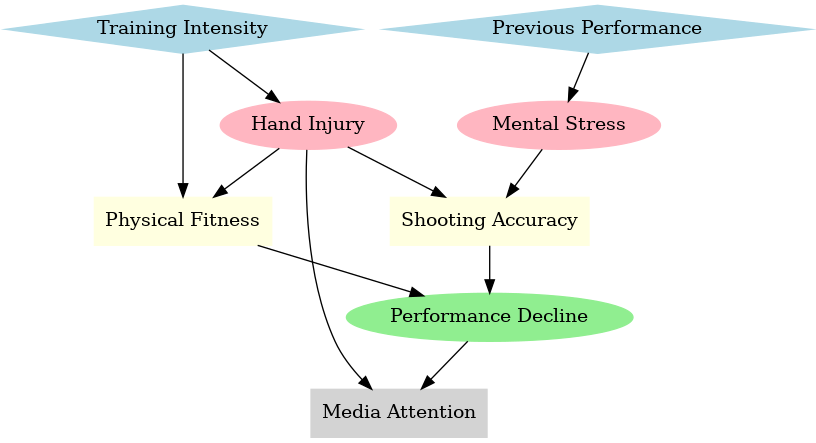

In [13]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [14]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

In light of Larisa Kuklina's emotional birthday celebration following her recent relay race, a closer look at her performance data could reveal intriguing patterns. By examining her race times, shooting accuracy, and results before and after her hand injury, we might uncover how such physical setbacks impact an athlete's overall performance. This exploration can shed light on the resilience and adaptability of athletes facing unexpected challenges.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the causal graph, and avoid using technical terms or jargon, but you can describe the variables and their relationships (including using terms like "affects

In [15]:
#################################################

structure_raw = '''

[
	{
		"sentence": "An athlete's hand injury, possibly resulting from intense training, plays a crucial role in shaping their physical fitness and accuracy in crucial skills like shooting.",
		"involved": ["Hand Injury", "Training Intensity", "Physical Fitness", "Shooting Accuracy"]
	},
	{
		"sentence": "The impact of psychological factors is evident, as the stress levels an athlete experiences, influenced by their past performance, can directly affect their precision in skills critical to their sport.",
		"involved": ["Mental Stress", "Previous Performance", "Shooting Accuracy"]
	},
	{
		"sentence": "Interestingly, the level of media attention an athlete receives is influenced not just by their current performance but also by their physical health, such as the presence of an injury.",
		"involved": ["Media Attention", "Performance Decline", "Hand Injury"]
	},
	{
		"sentence": "The overall performance of an athlete, as observed in their race times and results, is a complex interplay of their physical condition and their ability to perform key skills under pressure.",
		"involved": ["Performance Decline", "Physical Fitness", "Shooting Accuracy"]
	},
	{
		"sentence": "While the intensity of training is a key factor, it interestingly does not directly influence an athlete's performance but rather indirectly through its impact on their physical fitness and likelihood of injury.",
		"involved": ["Training Intensity", "Physical Fitness", "Hand Injury"]
	},
	{
		"sentence": "An athlete's past performance is a subtle yet influential factor, impacting not only their mental state but also indirectly shaping their skill execution during crucial moments.",
		"involved": ["Previous Performance", "Mental Stress", "Shooting Accuracy"]
	}
]



'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [16]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

In light of Larisa Kuklina's emotional birthday celebration following her recent relay race, a closer look at her performance data could reveal intriguing patterns. By examining her race times, shooting accuracy, and results before and after her hand injury, we might uncover how such physical setbacks impact an athlete's overall performance. This exploration can shed light on the resilience and adaptability of athletes facing unexpected challenges.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Training Intensity" is "High Intensity" (rather than "Low Intensity")?
2. when "Training Intensity" is "Low Intensity": what is the probability that "Hand Injury" is "Injury" (rather than "No Injury")?
3. when "Training Intensity" is "High Intensity": what is the probability tha

In [18]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''


{
  "1": [0.6, 0.7],
  "2": [0.1, 0.2],
  "3": [0.3, 0.4],
  "4": [0.5, 0.6],
  "5": [0.5, 0.6],
  "6": [0.2, 0.3],
  "7": [0.7, 0.8],
  "8": [0.8, 0.9],
  "9": [0.4, 0.5],
  "10": [0.5, 0.6],
  "11": [0.8, 0.9],
  "12": [0.6, 0.7],
  "13": [0.4, 0.5],
  "14": [0.2, 0.3],
  "15": [0.8, 0.9],
  "16": [0.6, 0.7],
  "17": [0.4, 0.5],
  "18": [0.1, 0.2],
  "19": [0.6, 0.7],
  "20": [0.5, 0.6],
  "21": [0.4, 0.5],
  "22": [0.7, 0.8]
}




'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [19]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

-------------------  ----------  -------  ---------------------------------------------------------------------------
Hand Injury          No Injury   Injury   Injury to the hand, affecting physical ability in biathlon.
Mental Stress        No Stress   Stress   Psychological stress potentially affecting performance.
Performance Decline  No Decline  Decline  Decline in biathlon performance, observable through race times and results.
-------------------  ----------  -------  ---------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


'Training Intensity' means Level of intensity in training sessions before the race.
'Hand Injury' means Injury to the hand, affecting physical ability in biathlon.
'Previous Performance' means Athlete's performance in prior events.
'Mental Stress' means Psychological stress potentially affecting performance.
'Physical Fitness' means Overall physical condition and fitness of the athlete.
'Shooting Accuracy' means Accuracy in shooting, a critical component in biathlon.
'Performance Decline' means Decline in biathlon performance, observable through race times and results.
'Media Attention' means Level of media attention received by the athlete.
Treatment Value    Treatment      Outcome Value    Outcome                    ATE    Correlation
-----------------  -------------  ---------------  -------------------  ---------  -------------
Injury             Hand Injury    Decline          Performance Decline  0.243818      0.00373056
Stress             Mental Stress  Decline          Performa

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


Treatment                                ATE    Correlation  Outcome
-------------------------------------  -----  -------------  -------------------------------------
High Intensity Training Intensity       0.2           -0.44  Injury Hand Injury
High Intensity Training Intensity       0              0     Good Performance Previous Performance
High Intensity Training Intensity       0              0     Stress Mental Stress
High Intensity Training Intensity       0.04          -0.07  High Fitness Physical Fitness
High Intensity Training Intensity      -0.08          -0.06  High Accuracy Shooting Accuracy
High Intensity Training Intensity       0             -0.01  Decline Performance Decline
High Intensity Training Intensity       0.01           0.08  High Attention Media Attention
Injury Hand Injury                     -0             -0.44  High Intensity Training Intensity
Injury Hand Injury                      0             -0     Good Performance Previous Performance
Injury Hand 

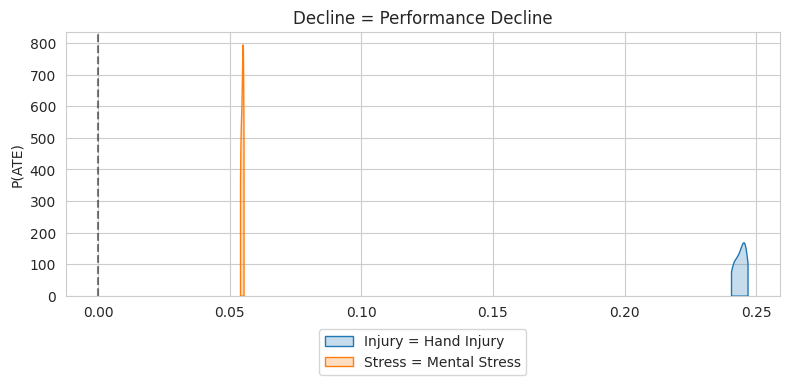

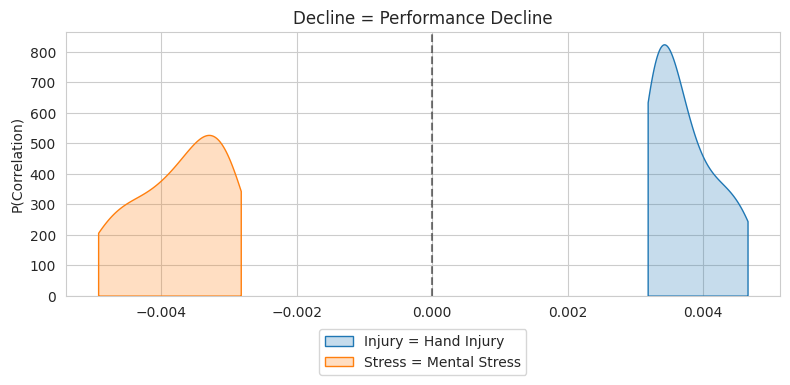

In [20]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [22]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Training Intensity' (0='Low Intensity', 1='High Intensity') means Level of intensity in training sessions before the race.
Variable 'Hand Injury' (0='No Injury', 1='Injury') means Injury to the hand, affecting physical ability in biat

In [23]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''

{
  "Training Intensity": {
    "descriptor": ["the intensity of training", "training regimen's rigor"],
    "subject": "athletes",
    "predicate0": ["train with less rigor", "engage in lighter training sessions"],
    "predicate1": ["undergo intense training", "engage in rigorous training sessions"],
    "pronoun": "they",
    "nounclause0": ["athletes engage in lighter training sessions", "training sessions are less intense"],
    "nounclause1": ["athletes undergo intense training", "training sessions are highly rigorous"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the training is not very rigorous", "there is a lighter training approach"],
    "subclause1": ["the training is highly intense", "there is a high level of training intensity"],
    "condition0": ["if the training intensity is low", "when athletes have lighter training sessions"],
    "condition1": ["if the training intensity is high", "when athletes undergo rigorous training"],
    "action0": ["if athletes reduce their training intensity", "if training sessions are made less rigorous"],
    "action1": ["if athletes increase their training intensity", "if training sessions are made more intense"]
  },
  "Hand Injury": {
    "descriptor": ["the presence of a hand injury", "hand injury status"],
    "subject": "an athlete",
    "predicate0": ["does not have a hand injury", "is free from hand injuries"],
    "predicate1": ["has a hand injury", "suffers from a hand injury"],
    "pronoun": "they",
    "nounclause0": ["an athlete does not have a hand injury", "there is no hand injury affecting the athlete"],
    "nounclause1": ["an athlete has a hand injury", "there is a hand injury affecting the athlete"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the athlete is not dealing with a hand injury", "there is no hand injury involved"],
    "subclause1": ["the athlete is dealing with a hand injury", "there is a hand injury involved"],
    "condition0": ["if there is no hand injury", "when an athlete is free from hand injuries"],
    "condition1": ["if there is a hand injury", "when an athlete has a hand injury"],
    "action0": ["if an athlete recovers from a hand injury", "if an athlete avoids a hand injury"],
    "action1": ["if an athlete sustains a hand injury", "if an athlete injures their hand"]
  },
  "Previous Performance": {
    "descriptor": ["the previous performance level", "past performance record"],
    "subject": "an athlete",
    "predicate0": ["had a poor past performance", "previously underperformed"],
    "predicate1": ["had a strong past performance", "previously excelled"],
    "pronoun": "they",
    "nounclause0": ["an athlete had a poor past performance", "the previous performance was below expectations"],
    "nounclause1": ["an athlete had a strong past performance", "the previous performance exceeded expectations"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the athlete did not perform well previously", "there was underperformance in past events"],
    "subclause1": ["the athlete performed well in the past", "there was outstanding performance in past events"],
    "condition0": ["if the past performance was poor", "when an athlete had underperformed previously"],
    "condition1": ["if the past performance was good", "when an athlete had excelled previously"],
    "action0": ["if an athlete improves from a poor past performance", "if an athlete overcomes past underperformance"],
    "action1": ["if an athlete maintains their good performance", "if an athlete continues to excel"]
  },
  "Mental Stress": {
    "descriptor": ["the level of mental stress", "psychological stress status"],
    "subject": "an athlete",
    "predicate0": ["is not experiencing mental stress", "is mentally relaxed"],
    "predicate1": ["is experiencing mental stress", "is mentally strained"],
    "pronoun": "they",
    "nounclause0": ["an athlete is not under mental stress", "there is no psychological pressure on the athlete"],
    "nounclause1": ["an athlete is experiencing mental stress", "psychological pressure is affecting the athlete"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the athlete is mentally at ease", "there is an absence of mental strain"],
    "subclause1": ["the athlete is under mental stress", "there is noticeable psychological strain"],
    "condition0": ["if the athlete is not mentally stressed", "when an athlete is mentally relaxed"],
    "condition1": ["if the athlete is mentally stressed", "when an athlete is facing mental strain"],
    "action0": ["if an athlete manages to alleviate mental stress", "if an athlete finds mental relaxation"],
    "action1": ["if an athlete becomes mentally stressed", "if psychological pressure mounts on the athlete"]
  },
  "Physical Fitness": {
    "descriptor": ["the level of physical fitness", "physical conditioning status"],
    "subject": "an athlete",
    "predicate0": ["is not in top physical shape", "has lower physical fitness"],
    "predicate1": ["is in top physical shape", "has high physical fitness"],
    "pronoun": "they",
    "nounclause0": ["an athlete is not at their peak physical condition", "physical fitness is not optimal"],
    "nounclause1": ["an athlete is in peak physical condition", "physical fitness is at its best"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the athlete's physical condition is not at its best", "there is a lack of optimal fitness"],
    "subclause1": ["the athlete is in excellent physical condition", "optimal fitness is maintained"],
    "condition0": ["if physical fitness is low", "when an athlete is not in top shape"],
    "condition1": ["if physical fitness is high", "when an athlete is in peak condition"],
    "action0": ["if an athlete's physical fitness deteriorates", "if there's a decline in physical conditioning"],
    "action1": ["if an athlete boosts their physical fitness", "if physical conditioning improves"]
  },
  "Shooting Accuracy": {
    "descriptor": ["the level of shooting accuracy", "accuracy in shooting"],
    "subject": "an athlete",
    "predicate0": ["is not very accurate in shooting", "has lower shooting accuracy"],
    "predicate1": ["is highly accurate in shooting", "has high shooting accuracy"],
    "pronoun": "they",
    "nounclause0": ["an athlete's shooting accuracy is low", "there is a lack of precision in shooting"],
    "nounclause1": ["an athlete's shooting accuracy is high", "shooting is done with great precision"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the athlete is struggling with shooting precision", "accuracy in shooting is not up to the mark"],
    "subclause1": ["the athlete excels in shooting accuracy", "there is remarkable precision in shooting"],
    "condition0": ["if shooting accuracy is low", "when an athlete struggles with shooting precision"],
    "condition1": ["if shooting accuracy is high", "when an athlete excels in shooting accuracy"],
    "action0": ["if an athlete's shooting accuracy decreases", "if precision in shooting drops"],
    "action1": ["if an athlete improves their shooting accuracy", "if there's an increase in shooting precision"]
  },
  "Performance Decline": {
    "descriptor": ["the trend in performance", "changes in athletic performance"],
    "subject": "an athlete",
    "predicate0": ["is maintaining their performance", "does not show a decline in performance"],
    "predicate1": ["is experiencing a decline in performance", "shows a downturn in their performance"],
    "pronoun": "they",
    "nounclause0": ["an athlete maintains their performance level", "there is no drop in performance"],
    "nounclause1": ["an athlete's performance is declining", "there is a noticeable drop in performance"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["the athlete continues to perform consistently", "performance levels remain steady"],
    "subclause1": ["the athlete faces a decline in their performance", "a downturn in performance is evident"],
    "condition0": ["if there is no performance decline", "when an athlete maintains their performance level"],
    "condition1": ["if there is a performance decline", "when an athlete's performance starts to fall"],
    "action0": ["if an athlete manages to maintain their performance", "if there's a sustained level of performance"],
    "action1": ["if an athlete experiences a drop in performance", "if performance levels start to decline"]
  },
  "Media Attention": {
    "descriptor": ["the level of media attention", "the media spotlight", "media coverage intensity"],
    "subject": "the athlete",
    "predicate0": ["receives minimal media coverage", "stays out of the media spotlight", "is not frequently featured in the media"],
    "predicate1": ["is frequently in the media spotlight", "receives extensive media coverage", "is often featured in the media"],
    "pronoun": "they",
    "nounclause0": ["the athlete receives minimal media attention", "the athlete stays out of the media spotlight", "the athlete is not frequently featured in the media"],
    "nounclause1": ["the athlete is frequently in the media spotlight", "the athlete receives extensive media attention", "the athlete is often featured in the media"],
    "preposition": ["among", "within"],
    "domain": ["athletes", "sports personalities"],
    "subclause0": ["media attention is minimal", "there is limited media coverage", "media spotlight is not intense"],
    "subclause1": ["media attention is high", "there is extensive media coverage", "media spotlight is intense"],
    "condition0": ["when media attention is low", "if there is minimal media coverage"],
    "condition1": ["when media attention is high", "if there is extensive media coverage"],
    "action0": ["media coverage is reduced", "the athlete steps out of the spotlight"],
    "action1": ["media coverage intensifies", "the athlete steps into the spotlight"]
  }
}
  

'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [24]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

In light of Larisa Kuklina's emotional birthday celebration following her recent relay race, a closer look at her performance data could reveal intriguing patterns. By examining her race times, shooting accuracy, and results before and after her hand injury, we might uncover how such physical setbacks impact an athlete's overall performance. This exploration can shed light on the resilience and adaptability of athletes facing unexpected challenges.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Hand Injury') > 0
	2. ATE('Mental Stress') > 0
	3. ATE('Hand Injury') > ATE('Mental Stress')
	4. |ATE('Mental Stress')| < |ATE('Hand Injury')|
	5. CATE('Hand Injury' | 'Training Intensity' = 0) < 0
	6. CATE('Mental Stress' | 'Training Intensity' = 0) > 0
	7.

In [25]:
# setting = ctx['questions']
#################################################
settings_raw = '''

{
    "1": {
        "question": "Does experiencing a hand injury typically lead to a decline in an athlete's performance?",
        "answer": "yes",
        "explanation": "An athlete's performance generally decreases following a hand injury."
    },
    "2": {
        "question": "Is an athlete likely to experience a decline in performance when under mental stress?",
        "answer": "yes",
        "explanation": "Mental stress often results in a deterioration of an athlete's performance."
    },
    "3": {
        "question": "Does a hand injury have a greater negative impact on an athlete's performance compared to mental stress?",
        "answer": "yes",
        "explanation": "The detrimental effect on performance is more pronounced due to a hand injury than due to mental stress."
    },
    "4": {
        "question": "Is the impact of mental stress on performance less severe compared to a hand injury?",
        "answer": "yes",
        "explanation": "The negative impact of a hand injury on an athlete's performance is typically more severe than that of mental stress."
    },
    "5": {
        "question": "For athletes with lower training intensity, does avoiding a hand injury lead to improved performance?",
        "answer": "yes",
        "explanation": "Athletes with lower training intensity tend to perform better when they do not have a hand injury."
    },
    "6": {
        "question": "For athletes with lower training intensity, does experiencing mental stress lead to improved performance?",
        "answer": "yes",
        "explanation": "Athletes with lower training intensity often see an improvement in performance when experiencing mental stress."
    },
    "7": {
        "question": "For athletes with lower training intensity, is the impact of mental stress on performance greater than that of a hand injury?",
        "answer": "yes",
        "explanation": "Among athletes with lower training intensity, mental stress has a more significant impact on performance than a hand injury."
    },
    "8": {
        "question": "For athletes with lower training intensity, is the impact of mental stress more pronounced compared to a hand injury?",
        "answer": "yes",
        "explanation": "The influence of mental stress on performance is more noticeable than that of a hand injury for athletes training at lower intensities."
    },
    "9": {
        "question": "For athletes with higher training intensity, does a hand injury typically result in reduced performance?",
        "answer": "yes",
        "explanation": "Athletes training at higher intensities often experience a decline in performance due to a hand injury."
    },
    "10": {
        "question": "For athletes with higher training intensity, does mental stress generally lead to better performance?",
        "answer": "yes",
        "explanation": "Athletes with higher training intensity tend to perform better under mental stress."
    },
    "11": {
        "question": "For athletes with higher training intensity, does mental stress have a lesser impact on performance compared to a hand injury?",
        "answer": "yes",
        "explanation": "In the context of higher training intensity, a hand injury affects an athlete's performance more than mental stress."
    },
    "12": {
        "question": "For athletes with higher training intensity, is the effect of a hand injury on performance more significant than that of mental stress?",
        "answer": "yes",
        "explanation": "The impact of a hand injury on performance is greater than that of mental stress for athletes who train more intensely."
    },
    "13": {
        "question": "Is the negative effect of a hand injury on performance less for athletes with higher training intensity compared to those with lower intensity?",
        "answer": "yes",
        "explanation": "Athletes with higher training intensity are less adversely affected by a hand injury compared to those with lower intensity."
    },
    "14": {
        "question": "Is the impact of a hand injury on performance more noticeable in athletes with higher training intensity than those with lower intensity?",
        "answer": "yes",
        "explanation": "The adverse effects of a hand injury are more evident in athletes with higher training intensity compared to those with lower intensity."
    },
    "15": {
        "question": "Do athletes with lower training intensity experience a greater impact from mental stress on their performance compared to those with higher intensity?",
        "answer": "yes",
        "explanation": "Athletes training at lower intensities are more affected by mental stress than those training at higher intensities."
    },
    "16": {
        "question": "Is the influence of mental stress on performance more substantial for athletes with higher training intensity compared to those with lower intensity?",
        "answer": "yes",
        "explanation": "Mental stress has a more pronounced effect on athletes with higher training intensity than on those with lower intensity."
    },
    "17": {
        "question": "For athletes with poor past performance, does a hand injury usually lead to improved performance?",
        "answer": "yes",
        "explanation": "Athletes who have had poor past performance often see an improvement in their performance following a hand injury."
    },
    "18": {
        "question": "For athletes with poor past performance, does mental stress typically result in a decline in performance?",
        "answer": "yes",
        "explanation": "Athletes who have previously performed poorly tend to experience a decrease in performance when under mental stress."
    },
    "19": {
        "question": "For athletes with poor past performance, does a hand injury have a greater positive impact on performance compared to mental stress?",
        "answer": "yes",
        "explanation": "Among athletes with a history of poor performance, the positive effect of a hand injury on performance is more significant than that of mental stress."
    },
    "20": {
        "question": "For athletes with poor past performance, is the positive impact of a hand injury on performance more significant than the negative impact of mental stress?",
        "answer": "yes",
        "explanation": "For athletes who have performed poorly in the past, the beneficial effect of a hand injury on performance outweighs the detrimental effect of mental stress."
    },
    "21": {
        "question": "For athletes with good past performance, does a hand injury typically lead to improved performance?",
        "answer": "yes",
        "explanation": "Athletes with a history of good performance often see an improvement in their performance following a hand injury."
    },
    "22": {
        "question": "For athletes with good past performance, does mental stress usually result in a decline in performance?",
        "answer": "yes",
        "explanation": "Athletes who have previously performed well tend to experience a decrease in performance when under mental stress."
    },
    "23": {
        "question": "For athletes with good past performance, does mental stress have a greater negative impact on performance compared to a hand injury?",
        "answer": "yes",
        "explanation": "Among athletes with a history of good performance, the negative effect of mental stress on performance is more significant than that of a hand injury."
    },
    "24": {
        "question": "For athletes with good past performance, is the negative impact of mental stress on performance more significant than that of a hand injury?",
        "answer": "yes",
        "explanation": "For athletes who have performed well in the past, the detrimental effect of mental stress on performance is greater than that of a hand injury."
    },
    "25": {
        "question": "Is the positive effect of a hand injury on performance less for athletes with good past performance compared to those with poor performance?",
        "answer": "yes",
        "explanation": "Athletes with a history of good performance are less positively impacted by a hand injury compared to those with a history of poor performance."
    },
    "26": {
        "question": "Is the positive impact of a hand injury on performance more noticeable in athletes with poor past performance than in those with good performance?",
        "answer": "yes",
        "explanation": "The beneficial effects of a hand injury on performance are more evident in athletes with a history of poor performance compared to those with good performance."
    },
    "27": {
        "question": "Do athletes with good past performance experience a greater impact from mental stress on their performance compared to those with poor performance?",
        "answer": "yes",
        "explanation": "Athletes with a history of good performance are more affected by mental stress than those with a history of poor performance."
    },
    "28": {
        "question": "Is the influence of mental stress on performance more substantial for athletes with poor past performance compared to those with good performance?",
        "answer": "yes",
        "explanation": "Mental stress has a more pronounced effect on athletes with a history of poor performance than on those with good performance."
    }
}




'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [26]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

"Larisa Kuklina's Performance and Injury Analysis.json"

In [27]:
ctx['stats'] = {int(k): v for k, v in ctx['stats'].items()}
ctx['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in ctx['verbs'].items()}
for k, v in ctx['verbs'].items():
    for k2, v2 in v.items():
        if 'value' in v2:
            v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
ctx['questions']['questions'] = {int(k): v for k, v in ctx['questions']['questions'].items()}

In [28]:
rawverbs = ctx['verbs']
rawvars = {node['name']: node for node in ctx['nodes']}

In [29]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('ParticipationAppleAcademy', 'EmploymentRateTech', ['LocalEconCond'])
('UnivIndustryCollab', 'EmploymentRateTech', ['LocalEconCond'])


In [30]:
qkey = random.choice(list(ctx['questions']['questions']))
qkey = 3
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][qkey-1]
print(ctx['query_description'].split('\n')[qkey-1])
print(query)
qinfo

	3. ATE('ParticipationAppleAcademy') < ATE('UnivIndustryCollab')
{'treatment1': 'ParticipationAppleAcademy', 'treatment2': 'UnivIndustryCollab', 'query': 'ate', 'type': 'ate-compare', 'criterion': '<'}


{'question': 'Is participating in the Apple Academy program more influential in increasing tech sector employment than active university-industry collaboration?',
 'answer': 'no',
 'explanation': 'Active university-industry collaboration tends to have a more significant impact on employment in the tech sector compared to individual participation in programs like Apple Academy.',
 'wrong_explanation': 'Participation in the Apple Academy program is more effective in increasing employment in the tech sector compared to university-industry collaboration.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [63]:
next(iter(rawverbs.values()))

{1: {'variable': ['the age of the refinery',
   'how long the refinery has been operational']},
 2: {'subject': 'the refinery',
  'value': {0: ['is a new facility', 'has been recently established'],
   1: ['has been operating for many years', 'is an older establishment']}},
 3: {'value': {0: ['the refinery is newly built',
    'the refinery has been recently established'],
   1: ['the refinery is quite old',
    'the refinery has many years of operation']}},
 4: {'domain': 'refineries',
  'value': {0: ['are new establishments', 'have been recently built'],
   1: ['are older facilities', 'have been operating for many years']}},
 5: {'value': {0: ['the refinery is a new establishment',
    'the refinery has been recently constructed'],
   1: ['the refinery is an old establishment',
    'the refinery has been operating for a long time']}},
 6: {'value': {0: ['If the refinery is newly established',
    'In newer refineries'],
   1: ['If the refinery has been around for many years',
    'In

In [ ]:
varverbs = {}

for var, raw in rawverbs.items():
    info = {'values': {0: {}, 1: {}}}
    info0 = info['values'][0]
    info1 = info['values'][1]
    
    info['variable'] = raw[1]['variable']
    info['subject'] = raw[2]['subject']
    info['domain'] = raw[3]['domain']
    
    
    
    for i in [0, 1]:
        info_val = raw[2]['value'][i]
        info_val['verb'] = raw[2]['value'][i]
        

    varverbs[var] = info

In [62]:
rawverbs[treatment1['name']]

{1: {'variable': ['the safety protocols in place at the refinery',
   'how well the refinery follows safety guidelines']},
 2: {'subject': 'the refinery',
  'value': {0: ['lacks adequate safety protocols',
    'has insufficient safety measures'],
   1: ['maintains adequate safety protocols', 'has robust safety measures']}},
 3: {'value': {0: ['safety protocols are inadequate',
    'safety measures are not up to standard'],
   1: ['safety protocols are thoroughly implemented',
    'safety measures are comprehensive']}},
 4: {'domain': 'refineries',
  'value': {0: ['lack adequate safety measures',
    'do not follow safety guidelines properly'],
   1: ['have robust safety protocols',
    'adhere strictly to safety guidelines']}},
 5: {'value': {0: ['safety protocols are not followed properly',
    'safety measures are neglected'],
   1: ['safety protocols are strictly followed',
    'safety measures are taken seriously']}},
 6: {'value': {0: ['If safety protocols are lacking',
    'In re

In [28]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
example_tmpl = '{subject} often {value}.'

In [35]:
rawverbs

{'Presidential Engagement in Climate Discussions': {'1': {'variable': ['presidential involvement in climate talks',
    "the president's active participation in climate discussions"]},
  '2': {'subject': 'the president',
   'value': {'0': ['is not involved in climate discussions',
     'does not engage in climate talks'],
    '1': ['actively participates in climate discussions',
     'is deeply involved in climate talks']}},
  '3': {'value': {'0': ['the president is not engaged in climate talks',
     'there is no presidential involvement in climate discussions'],
    '1': ['the president is actively engaged in climate talks',
     'there is direct presidential involvement in climate discussions']}},
  '4': {'domain': 'instances of climate discussions',
   'value': {'0': ['do not include presidential engagement',
     "lack the president's involvement"],
    '1': ['include active presidential participation',
     "feature the president's active involvement"]}},
  '5': {'value': {'0': [

In [80]:
prompt = FileTemplate('motivation').fill_in(ctx)
print(prompt)

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "mode

In [77]:
{
  "introduction": "With the rise of quantum computing posing a real challenge to current encryption methods, there's a fascinating question about how prepared different tech companies are for this change. By examining the patterns in investments made by these companies into quantum-safe technologies, we can get a sense of who's leading and who might be lagging in this race. This exploration would involve looking at the amount and types of investments over the past few years, delving into the sectors these companies belong to, and assessing their geographical distribution.",
  "title": "Quantum_Leap_In_Encryption_Preparedness"
}


{'introduction': "Imagine we're tracking a high-stakes race where companies around the world are scrambling to make their secrets quantum-proof. We'd gather data on how different start-ups are updating their encryption methods, noting things like the type of technology they're using, their progress speed, and the investments they're receiving. By looking at these pieces, we can understand who's leading in this crucial tech shift and what strategies are proving most effective.",
 'proposed_title': 'QuantumLeap_EncryptionRace'}

In [ ]:

# For example, if the article is about some political decision or issue in the economy, then we can imagine using that article (and some implied associated data) to analyze how some specific company should adjust investments or how some associated economic indicator will change. 


In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args